# Airline Passengers Time Series Analysis

**Univariate time series forecasting**

**Author: Wade Evans**   
Reference: https://www.kaggle.com/andreazzini/international-airline-passengers

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [2]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# Check index type (datetime) and freq
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [7]:
# Set index frequency
# 'MS' = monthly start
df.index.freq = 'MS'

In [8]:
# Check index type (datetime) and freq
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [9]:
# Check for missing values
df.isnull().sum()

Thousands of Passengers    0
dtype: int64

## ETS (Error / Trend / Seasonality Models)

<AxesSubplot:xlabel='Month'>

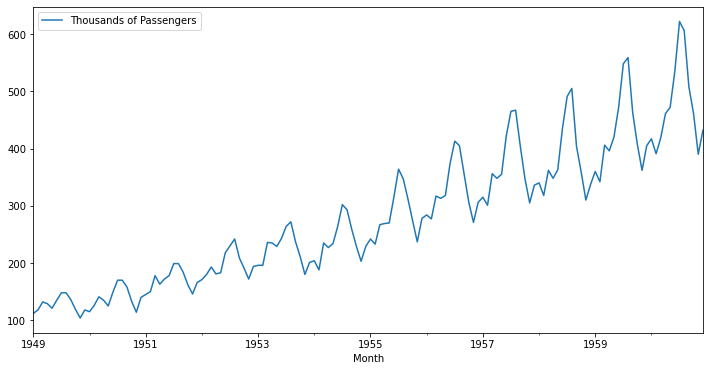

In [10]:
df.plot(figsize=(12,6))

Appears to be an increasing trend.   
Appears to be seasonality, which is growing at an exponential rate.   
   
Note, we apply an   
* additive model when the trend is more linear and the seasonality and trend components seem to be constant over time.
* multiplicative model when increasing / decreasing at a non-linear rate.
   
Based on the above, a multiplicative model will be applied.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
result = seasonal_decompose(df['Thousands of Passengers'],model='multiplicative')

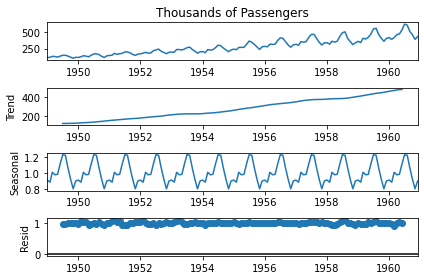

In [13]:
result.plot(); # semi-colon prevents showing the plots twice

May plot the components one by one:

<AxesSubplot:xlabel='Month'>

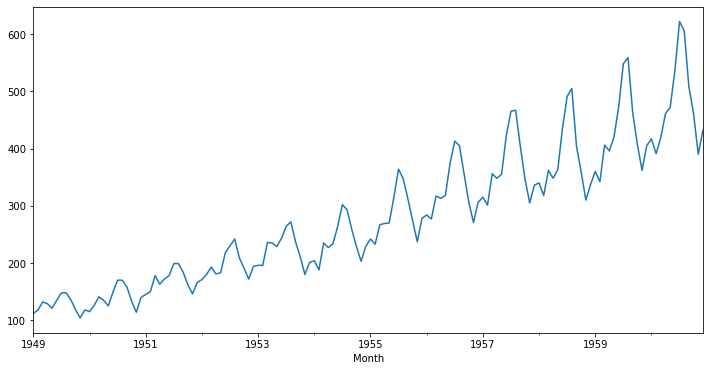

In [14]:
result.observed.plot(figsize=(12,6))

<AxesSubplot:xlabel='Month'>

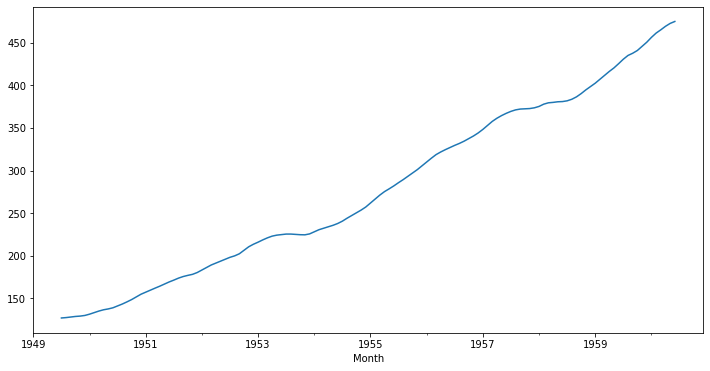

In [15]:
result.trend.plot(figsize=(12,6))

<AxesSubplot:xlabel='Month'>

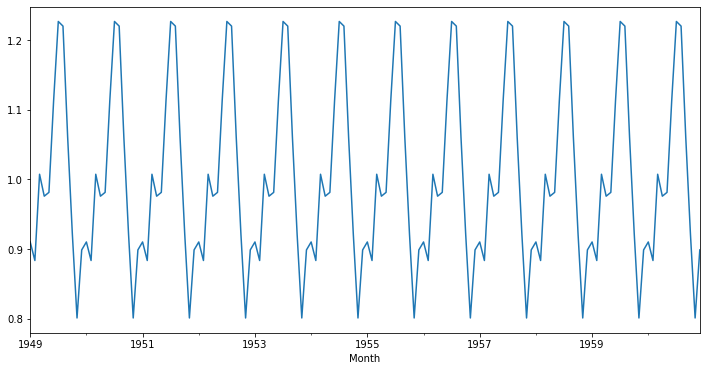

In [16]:
result.seasonal.plot(figsize=(12,6))

<AxesSubplot:xlabel='Month'>

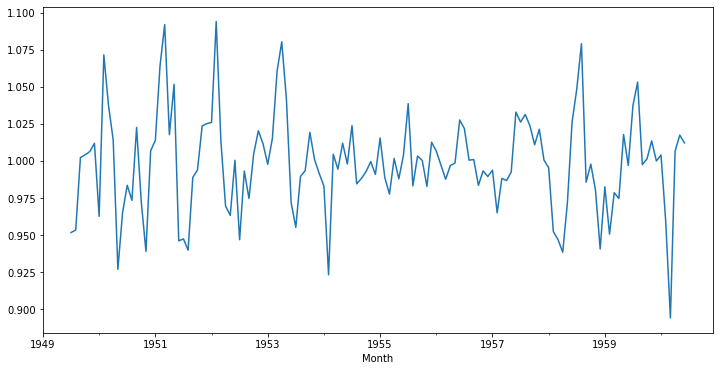

In [17]:
result.resid.plot(figsize=(12,6))

Looking at the residuals, there is more noise in the beginning and ends of the data (less certainty).

# Simple Moving Averages

Apply a mean function to a rolling window.

In [18]:
# rolling(window=n)
    # n = size of the moving window.
    # This is the number of observations used for calculating the statistic.
    # Each window will be a fixed size.
df['6monthSMA'] = df['Thousands of Passengers'].rolling(window=6).mean()
df['12monthSMA'] = df['Thousands of Passengers'].rolling(window=12).mean()

In [19]:
df

,Thousands of Passengers,6monthSMA,12monthSMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
...,...,...,...
1960-08-01,606,519.166667,463.333333
1960-09-01,508,534.000000,467.083333
1960-10-01,461,534.000000,471.583333


<AxesSubplot:xlabel='Month'>

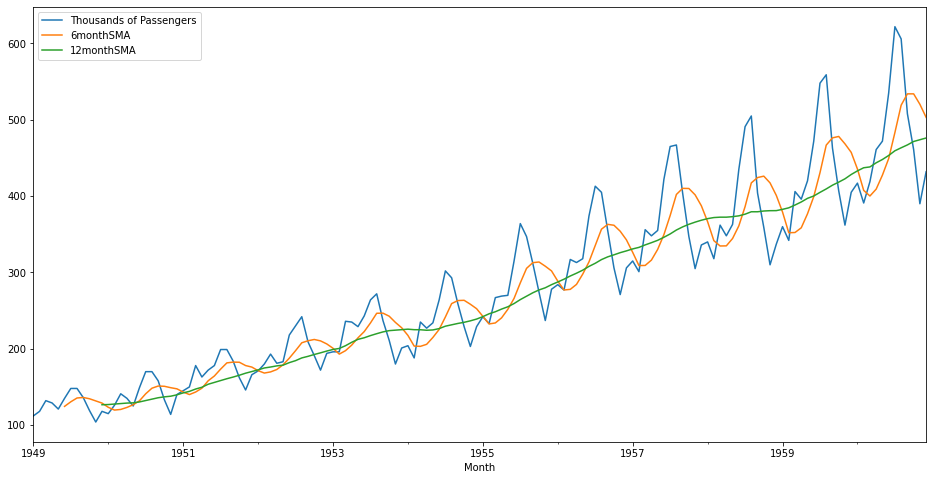

In [20]:
df.plot(figsize=(16,8))

Note the missing data at the beginning for the SMA curves.

## Evaluate

**Using scikit learn**

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
df.dropna()['Thousands of Passengers']

Month
1949-12-01    118
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Thousands of Passengers, Length: 133, dtype: int64

In [23]:
# RMSE of 6 month SMA
np.sqrt(mean_squared_error(df.dropna()['Thousands of Passengers'],df.dropna()['6monthSMA']))

46.62867008452305

In [24]:
# RMSE of 12 month SMA
np.sqrt(mean_squared_error(df.dropna()['Thousands of Passengers'],df.dropna()['12monthSMA']))

48.00924259647008

**Using statsmodels**

In [25]:
from statsmodels.tools.eval_measures import rmse

In [26]:
# RMSE of 6 month SMA
rmse(df.dropna()['Thousands of Passengers'],df.dropna()['6monthSMA'])

46.62867008452305

In [27]:
# RMSE of 12 month SMA
rmse(df.dropna()['Thousands of Passengers'],df.dropna()['12monthSMA'])

48.00924259647008

# Exponentially Weighted Moving Average

In [28]:
# adjust = False
df['EWMA12_adjust_false'] = df['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

In [29]:
# adjust = True
df['EWMA12_adjust_true'] = df['Thousands of Passengers'].ewm(span=12,adjust=True).mean()

In [30]:
df.head()

,Thousands of Passengers,6monthSMA,12monthSMA,EWMA12_adjust_false,EWMA12_adjust_true
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,115.250000
1949-03-01,132,NaN,NaN,115.857988,121.787529
1949-04-01,129,NaN,NaN,117.879836,124.064224
1949-05-01,121,NaN,NaN,118.359861,123.231685


In [31]:
df.columns

Index(['Thousands of Passengers', '6monthSMA', '12monthSMA',
       'EWMA12_adjust_false', 'EWMA12_adjust_true'],
      dtype='object')

<AxesSubplot:xlabel='Month'>

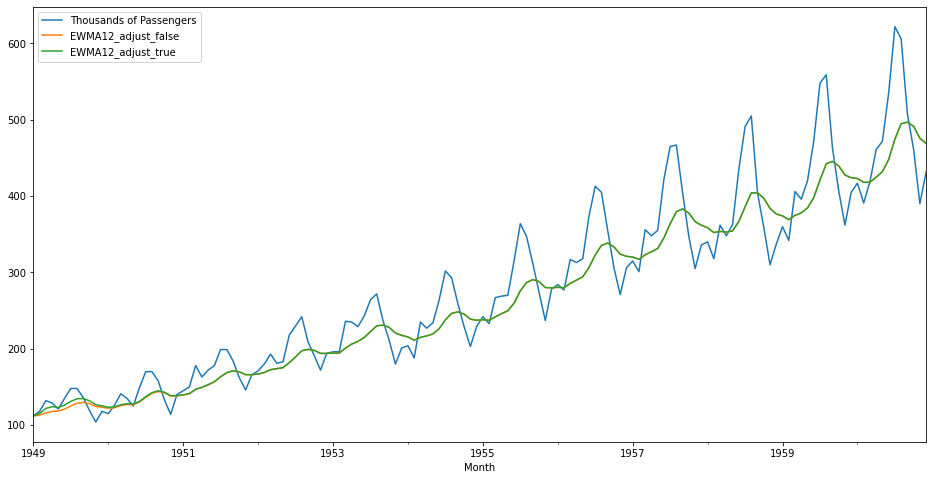

In [32]:
df[['Thousands of Passengers','EWMA12_adjust_false', 'EWMA12_adjust_true']].plot(figsize=(16,8))

Note that there is no missing data at the beginning of the EWMA curves, unlike for SMA.

**Compare span=6 and span=12 with adjust=True**

In [33]:
# adjust = True
df['EWMA6_adjust_true'] = df['Thousands of Passengers'].ewm(span=6,adjust=True).mean()

<AxesSubplot:xlabel='Month'>

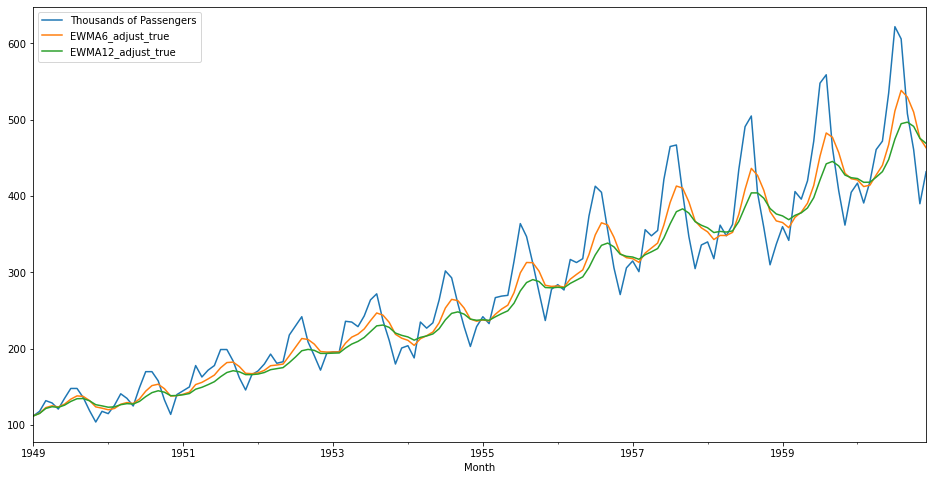

In [34]:
df[['Thousands of Passengers','EWMA6_adjust_true', 'EWMA12_adjust_true']].plot(figsize=(16,8))

## Evaluate

In [35]:
# RMSE of EWMA, span = 12, adjust = False
rmse(df['Thousands of Passengers'],df['EWMA12_adjust_false'])

41.394445345698706

In [36]:
# RMSE of EWMA, span = 12, adjust = True
rmse(df['Thousands of Passengers'],df['EWMA12_adjust_true'])

41.312675718459396

In [37]:
# RMSE of EWMA, span = 6, adjust = True
rmse(df['Thousands of Passengers'],df['EWMA6_adjust_true'])

32.825310766356665

# Holt-Winters Methods

In EWMA, Simple Exponential Smoothing was applied using only one smoothing factor. This fails to account for contributing factors such as trend and seasonality.   
Double Exponential Smoothing (Holt's Method) introduces a new smoothing factor that addresses trend.   
Triple Exponentual Smoothing (Holt-Winters Method) introduces a further smoothing factor that addresses seasonality.

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [39]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',
                                      seasonal='mul',seasonal_periods=12).fit().fittedvalues

C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [40]:
df.head()

,Thousands of Passengers,6monthSMA,12monthSMA,EWMA12_adjust_false,EWMA12_adjust_true,EWMA6_adjust_true,TESmul12
Month,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,112.000000,111.596793
1949-02-01,118,NaN,NaN,112.923077,115.250000,115.500000,118.841794
1949-03-01,132,NaN,NaN,115.857988,121.787529,122.917431,133.334074
1949-04-01,129,NaN,NaN,117.879836,124.064224,125.266892,127.898917
1949-05-01,121,NaN,NaN,118.359861,123.231685,123.769332,120.977474


<AxesSubplot:xlabel='Month'>

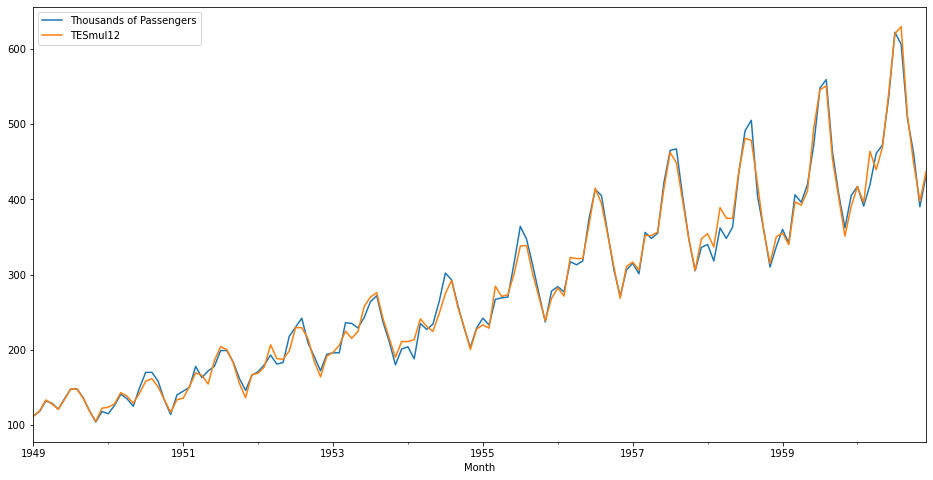

In [41]:
df[['Thousands of Passengers','TESmul12']].plot(figsize=(16,8))

**Compare seasonal_periods=12 and seasonal_periods=6**

In [42]:
df['TESmul6'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',
                                      seasonal='mul',seasonal_periods=6).fit().fittedvalues

C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<AxesSubplot:xlabel='Month'>

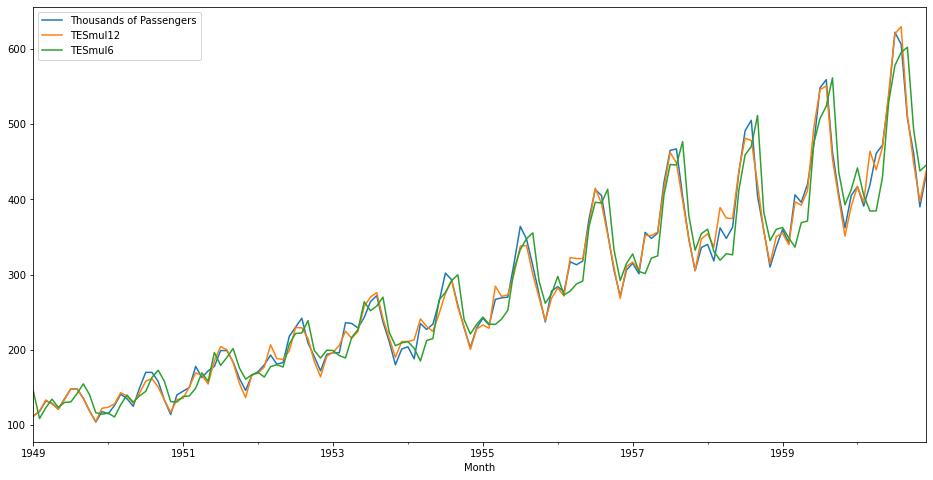

In [43]:
df[['Thousands of Passengers','TESmul12','TESmul6']].plot(figsize=(16,8))

## Evaluate

In [44]:
# RMSE of Triple Exponential Smoothing, periods=12
rmse(df['Thousands of Passengers'],df['TESmul12'])

10.476593317852494

In [45]:
# RMSE of Triple Exponential Smoothing, periods=6
rmse(df['Thousands of Passengers'],df['TESmul6'])

28.450458866261727

## Forecasting with the Holt-Winters Method (Triple Exponential Smoothing)

## Train Test Split

In [46]:
df.head()

,Thousands of Passengers,6monthSMA,12monthSMA,EWMA12_adjust_false,EWMA12_adjust_true,EWMA6_adjust_true,TESmul12,TESmul6
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,112.000000,111.596793,144.885323
1949-02-01,118,NaN,NaN,112.923077,115.250000,115.500000,118.841794,108.648816
1949-03-01,132,NaN,NaN,115.857988,121.787529,122.917431,133.334074,122.923365
1949-04-01,129,NaN,NaN,117.879836,124.064224,125.266892,127.898917,134.449591
1949-05-01,121,NaN,NaN,118.359861,123.231685,123.769332,120.977474,123.421263


In [47]:
df.tail()

,Thousands of Passengers,6monthSMA,12monthSMA,EWMA12_adjust_false,EWMA12_adjust_true,EWMA6_adjust_true,TESmul12,TESmul6
Month,,,,,,,,
1960-08-01,606,519.166667,463.333333,494.898619,494.898620,538.549357,629.401477,595.284765
1960-09-01,508,534.000000,467.083333,496.914216,496.914217,529.820969,511.999868,602.045347
1960-10-01,461,534.000000,471.583333,491.388952,491.388952,510.157835,448.034587,492.473831
1960-11-01,390,520.333333,473.916667,475.790652,475.790652,475.827025,397.252170,437.661556
1960-12-01,432,503.166667,476.166667,469.053629,469.053629,463.305018,437.148988,445.239492


In [48]:
len(df)

144

In [49]:
df.columns

Index(['Thousands of Passengers', '6monthSMA', '12monthSMA',
       'EWMA12_adjust_false', 'EWMA12_adjust_true', 'EWMA6_adjust_true',
       'TESmul12', 'TESmul6'],
      dtype='object')

In [50]:
# Exclude last 12 months of data for training set
train_data = df.drop(['6monthSMA', '12monthSMA',
       'EWMA12_adjust_false', 'EWMA12_adjust_true', 'EWMA6_adjust_true',
       'TESmul12', 'TESmul6'],axis=1).iloc[:(len(df)-12)]

In [51]:
# Last 12 months of data for testing set
test_data = df.drop(['6monthSMA', '12monthSMA',
       'EWMA12_adjust_false', 'EWMA12_adjust_true', 'EWMA6_adjust_true',
       'TESmul12', 'TESmul6'],axis=1).iloc[(len(df)-12):]

In [52]:
len(train_data)

132

In [53]:
len(test_data)

12

In [54]:
train_data

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


In [55]:
test_data

,Thousands of Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


## Fit the model

In [56]:
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',
                                    seasonal='mul',seasonal_periods=12).fit()

C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [57]:
test_predictions = fitted_model.forecast(12).rename('Holt-Winters Forecast')

In [58]:
test_predictions

1960-01-01    420.908729
1960-02-01    399.217288
1960-03-01    470.320232
1960-04-01    458.256643
1960-05-01    483.833504
1960-06-01    556.247797
1960-07-01    644.520692
1960-08-01    654.622367
1960-09-01    537.145833
1960-10-01    470.787513
1960-11-01    414.193741
1960-12-01    448.649078
Freq: MS, Name: Holt-Winters Forecast, dtype: float64

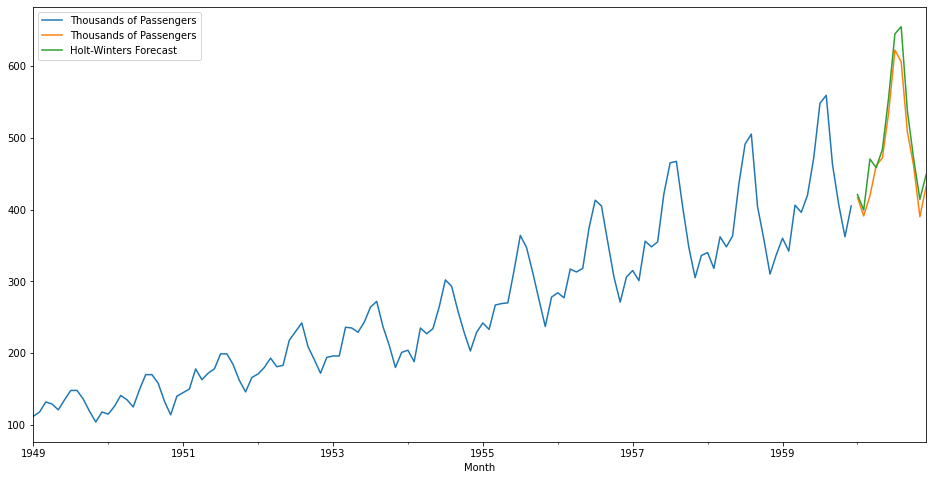

In [59]:
train_data['Thousands of Passengers'].plot(figsize=(16,8))
test_data['Thousands of Passengers'].plot()
test_predictions.plot()
plt.legend()

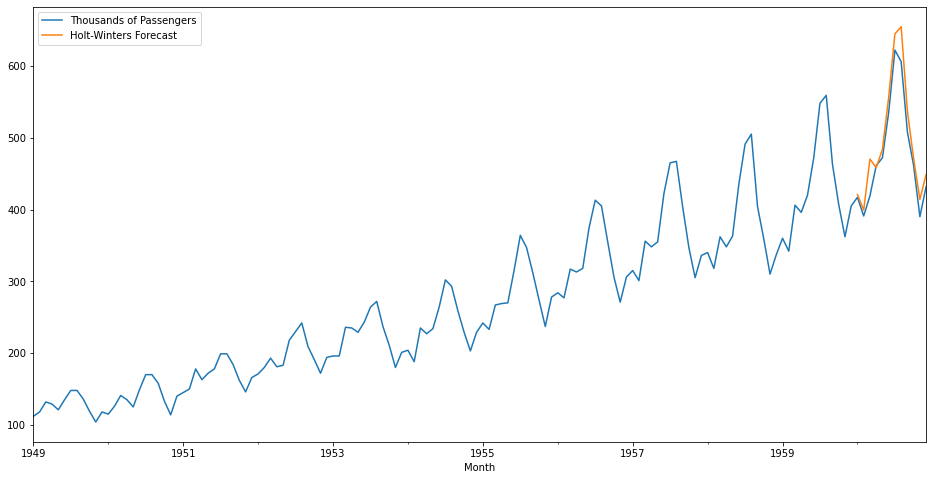

In [60]:
df['Thousands of Passengers'].plot(figsize=(16,8))
test_predictions.plot()
plt.legend()

## Evaluate

In [61]:
# RMSE of Triple Exponential Smoothing, periods=12
rmse(test_data['Thousands of Passengers'],test_predictions)

25.81135901063159

In [62]:
# Use these stats to compare the RMSE with (e.g. compare the mean and std with RMSE)
test_data.describe()

,Thousands of Passengers
count,12.000000
mean,476.166667
std,77.737125
min,390.000000
25%,418.500000
50%,461.000000
75%,514.750000
max,622.000000


## Forecasting into the future

In [63]:
# Re-train on the entire dataframe
final_model = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',
                                    seasonal='mul',seasonal_periods=12).fit()

C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [64]:
forecast_predictions = final_model.forecast(12)

In [65]:
forecast_predictions

1961-01-01    450.675302
1961-02-01    424.818510
1961-03-01    475.494744
1961-04-01    504.076271
1961-05-01    517.871918
1961-06-01    590.145478
1961-07-01    684.227074
1961-08-01    678.030847
1961-09-01    567.111774
1961-10-01    507.823777
1961-11-01    434.718565
1961-12-01    485.979996
Freq: MS, dtype: float64

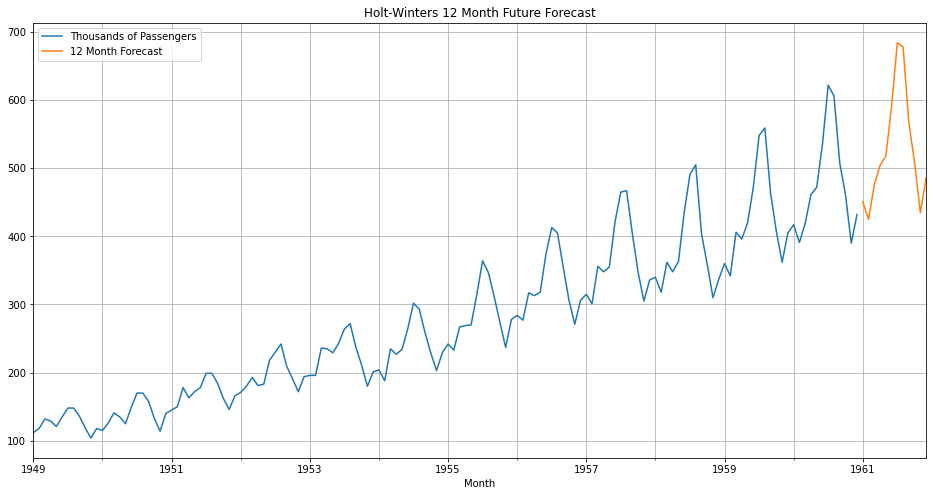

In [66]:
df['Thousands of Passengers'].plot(figsize=(16,8))
forecast_predictions.plot()
plt.legend(['Thousands of Passengers','12 Month Forecast'])
plt.title('Holt-Winters 12 Month Future Forecast')
plt.grid(which='both')

# Facebook Prophet

In [67]:
from prophet import Prophet

In [68]:
# Note that we do not set index_col and parse_dates
    # Prophet requires a specific format
df = pd.read_csv('airline_passengers.csv')

In [69]:
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [70]:
# Rename the columns (required for Prophet)
df.columns = ('ds','y')

In [71]:
df['ds'] = pd.to_datetime(df['ds'])

In [72]:
df['ds']

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: ds, Length: 144, dtype: datetime64[ns]

In [73]:
df.head(3)

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132


<AxesSubplot:xlabel='ds'>

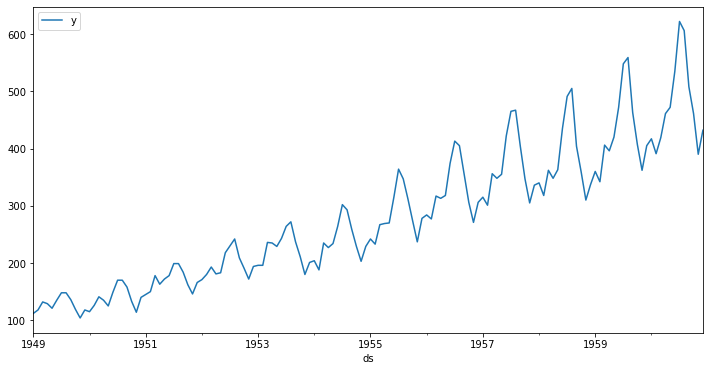

In [74]:
df.plot(x='ds',y='y',figsize=(12,6))

## Create and fit the model

In [75]:
m = Prophet()

In [76]:
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecasting

**Create 'future' placeholder dataframe (to hold future predictions)**

In [77]:
future = m.make_future_dataframe(periods=12,freq='MS')

In [78]:
df

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [79]:
future

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
151,1961-08-01
152,1961-09-01
153,1961-10-01
154,1961-11-01


'future' has 12 more rows than 'df'

**Predict and fill in the future**

In [80]:
forecast = m.predict(future)

In [81]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.320611,57.061933,112.811544,106.320611,106.320611,-21.941934,-21.941934,-21.941934,-21.941934,-21.941934,-21.941934,0.0,0.0,0.0,84.378677
1,1949-02-01,108.500995,50.600817,106.573208,108.500995,108.500995,-30.714169,-30.714169,-30.714169,-30.714169,-30.714169,-30.714169,0.0,0.0,0.0,77.786826
2,1949-03-01,110.470374,80.187549,138.839758,110.470374,110.470374,-0.475833,-0.475833,-0.475833,-0.475833,-0.475833,-0.475833,0.0,0.0,0.0,109.994541
3,1949-04-01,112.650758,79.940850,137.603780,112.650758,112.650758,-5.203855,-5.203855,-5.203855,-5.203855,-5.203855,-5.203855,0.0,0.0,0.0,107.446903
4,1949-05-01,114.760808,84.363159,141.537993,114.760808,114.760808,-3.825854,-3.825854,-3.825854,-3.825854,-3.825854,-3.825854,0.0,0.0,0.0,110.934953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1961-08-01,508.960446,549.988176,604.387006,508.617828,509.217372,67.973548,67.973548,67.973548,67.973548,67.973548,67.973548,0.0,0.0,0.0,576.933994
152,1961-09-01,512.075918,499.449369,558.482253,511.668391,512.397723,16.329618,16.329618,16.329618,16.329618,16.329618,16.329618,0.0,0.0,0.0,528.405536
153,1961-10-01,515.090891,464.148790,521.949512,514.611412,515.477480,-21.972456,-21.972456,-21.972456,-21.972456,-21.972456,-21.972456,0.0,0.0,0.0,493.118435
154,1961-11-01,518.206363,430.390545,489.354867,517.653838,518.670461,-58.940239,-58.940239,-58.940239,-58.940239,-58.940239,-58.940239,0.0,0.0,0.0,459.266124


## Plotting forecast

Text(0.5, 1.0, 'Facebook Prophet - 12 Month Future Forecast')

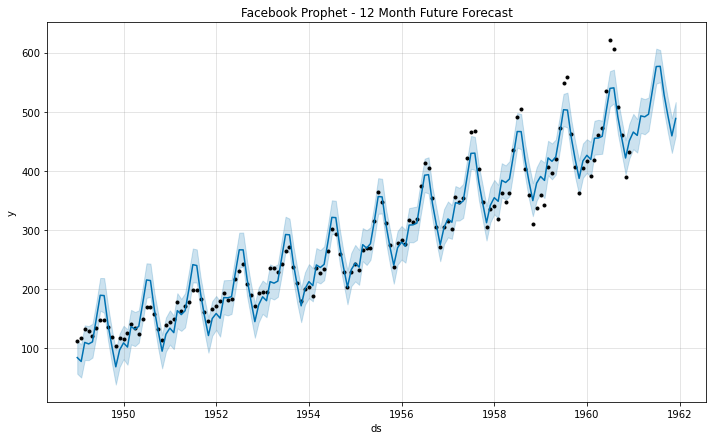

In [82]:
m.plot(forecast);
plt.title('Facebook Prophet - 12 Month Future Forecast')

(array(-5114.), array(-2953.))

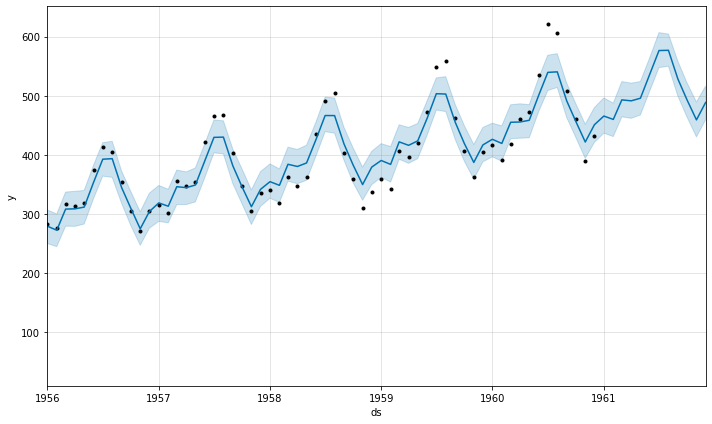

In [83]:
# Zoomed in plot
m.plot(forecast);
plt.xlim('1956-01-01','1961-12-01')

Text(0.5, 1.0, 'Facebook Prophet - 12 Month Future Forecast')

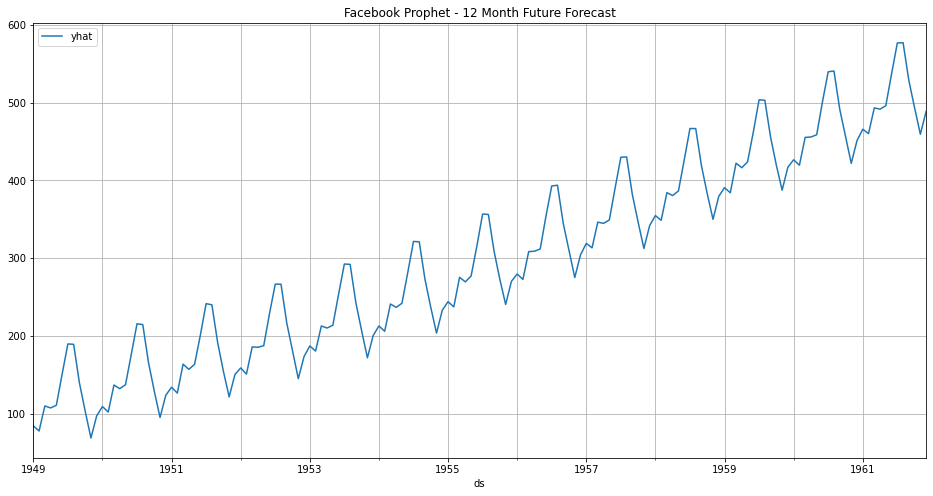

In [84]:
forecast.plot(x='ds',y='yhat',figsize=(16,8))
plt.grid(which='both')
plt.title('Facebook Prophet - 12 Month Future Forecast')

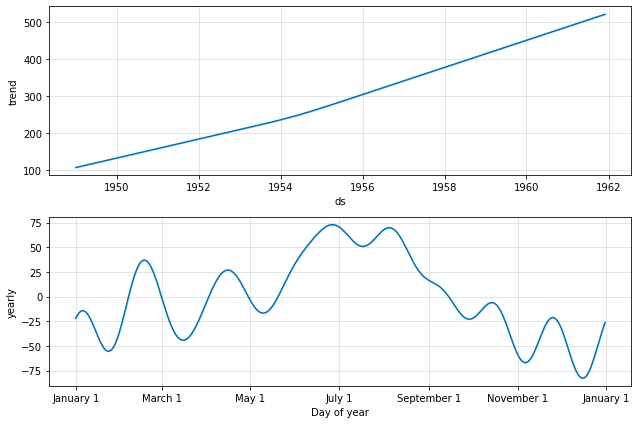

In [85]:
m.plot_components(forecast);

## Evaluate Prophet Forecast

## Test Train Split

In [86]:
train = df.iloc[:(len(df)-12)]
test = df.iloc[(len(df)-12):]

## Create and fit the model

In [87]:
m = Prophet()

In [88]:
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
future = m.make_future_dataframe(periods=12,freq='MS')

In [90]:
future

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01


In [91]:
len(train)

132

In [92]:
len(test)

12

Note that this 'future' is the length of the original dataframe (df), not 12 periods more like the previous 'future' used when forecasting. However, it is 12 periods longer than the 'train' dataframe (we predict from the end of 'train' rather than the end of 'df'). Here, we are only evaluating against the last 12 periods of 'df' (i.e. 'test'), not forecasting into the future.

In [93]:
forecast = m.predict(future)

In [94]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,109.214736,58.690684,109.049150,109.214736,109.214736,-23.958556,-23.958556,-23.958556,-23.958556,-23.958556,-23.958556,0.0,0.0,0.0,85.256180
1,1949-02-01,111.367591,55.025521,106.924832,111.367591,111.367591,-32.491925,-32.491925,-32.491925,-32.491925,-32.491925,-32.491925,0.0,0.0,0.0,78.875666
2,1949-03-01,113.312105,91.534022,142.273681,113.312105,113.312105,3.262693,3.262693,3.262693,3.262693,3.262693,3.262693,0.0,0.0,0.0,116.574798
3,1949-04-01,115.464960,81.493019,134.800628,115.464960,115.464960,-6.123334,-6.123334,-6.123334,-6.123334,-6.123334,-6.123334,0.0,0.0,0.0,109.341626
4,1949-05-01,117.548368,84.701492,137.674167,117.548368,117.548368,-5.280722,-5.280722,-5.280722,-5.280722,-5.280722,-5.280722,0.0,0.0,0.0,112.267646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,467.731086,502.007515,553.070042,467.445671,467.983717,59.348436,59.348436,59.348436,59.348436,59.348436,59.348436,0.0,0.0,0.0,527.079522
140,1960-09-01,470.746827,461.319487,512.006897,470.399504,471.072734,15.122382,15.122382,15.122382,15.122382,15.122382,15.122382,0.0,0.0,0.0,485.869209
141,1960-10-01,473.665286,427.213878,478.921336,473.240289,474.042775,-21.462924,-21.462924,-21.462924,-21.462924,-21.462924,-21.462924,0.0,0.0,0.0,452.202363
142,1960-11-01,476.681028,395.840665,447.939350,476.162396,477.130587,-54.308372,-54.308372,-54.308372,-54.308372,-54.308372,-54.308372,0.0,0.0,0.0,422.372655


Text(0.5, 1.0, 'Facebook Prophet - Evaluation')

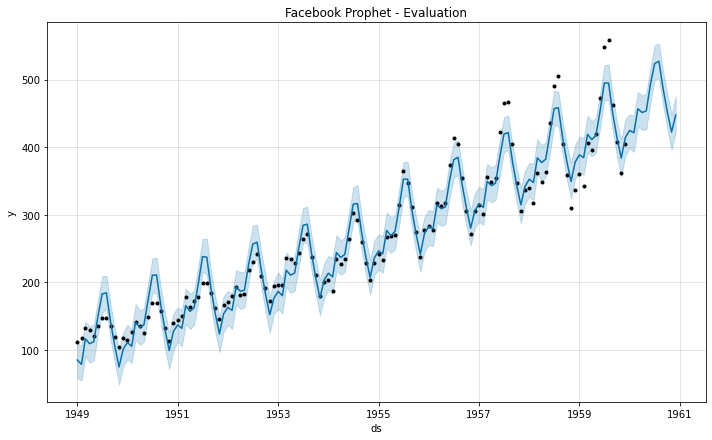

In [95]:
m.plot(forecast);
plt.title('Facebook Prophet - Evaluation')

<AxesSubplot:xlabel='ds'>

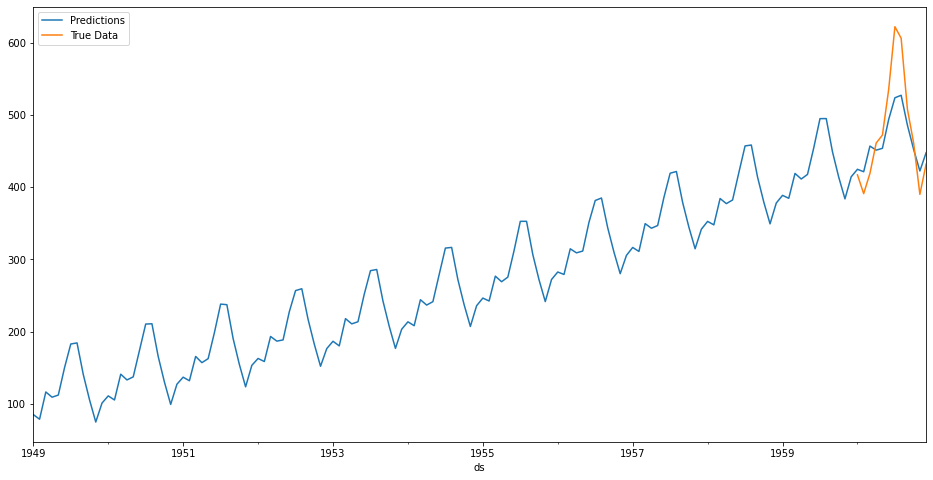

In [96]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(16,8))
test.plot(x='ds',y='y',label='True Data',legend=True,ax=ax)

<AxesSubplot:xlabel='ds'>

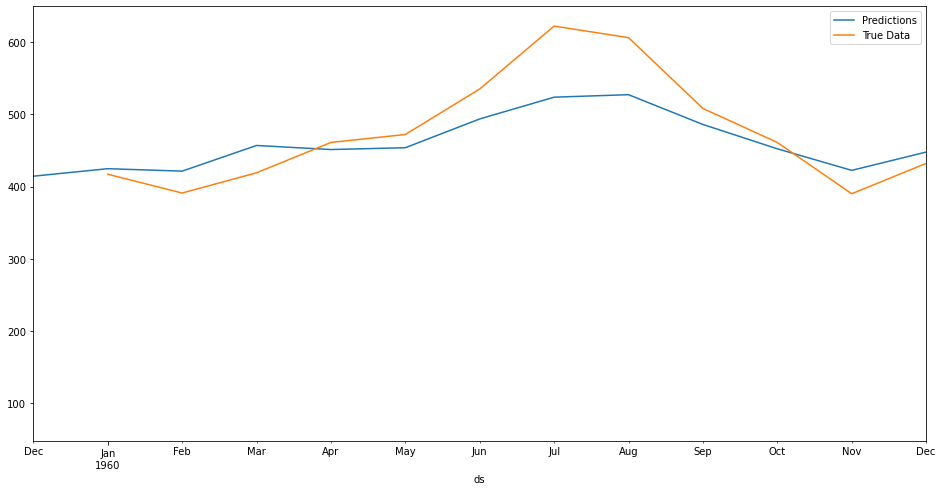

In [97]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(16,8))
test.plot(x='ds',y='y',label='True Data',legend=True,ax=ax,xlim=('1959-12-01','1960-12-01'))

## Trend Changes

In [98]:
from prophet.plot import add_changepoints_to_plot

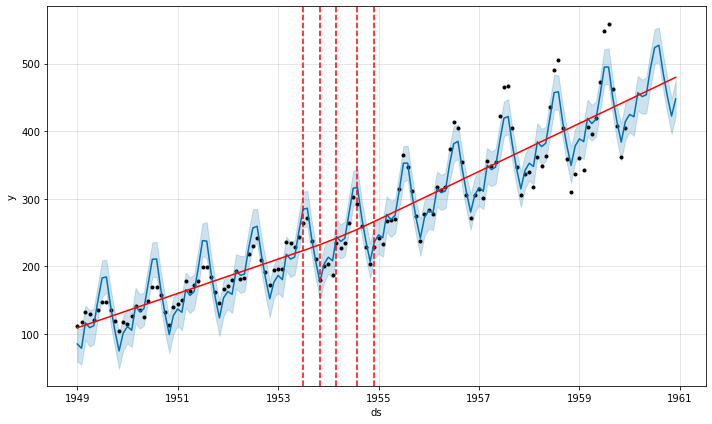

In [99]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)

## Changing Seasonality

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


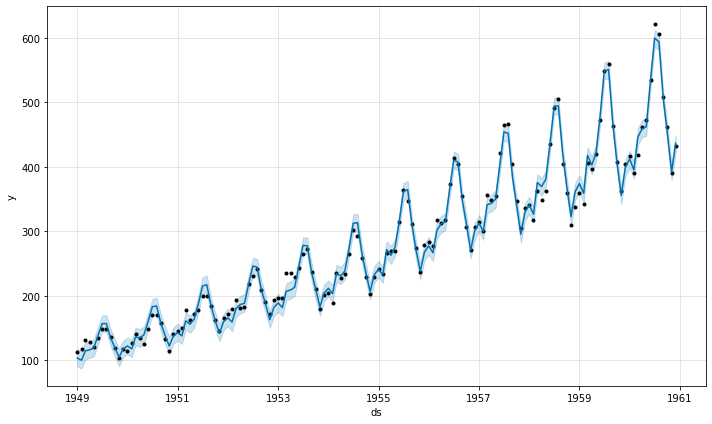

In [100]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

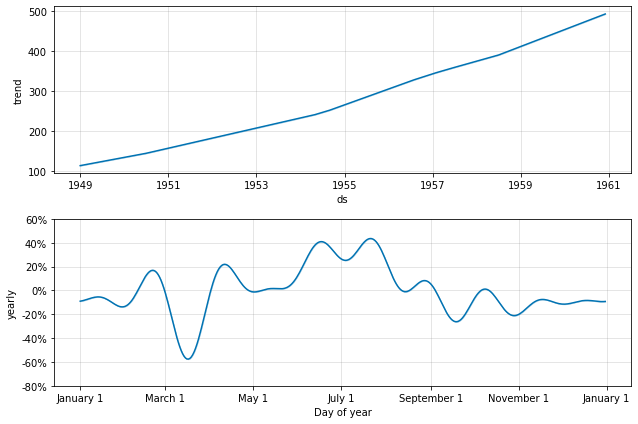

In [101]:
fig = m.plot_components(forecast)

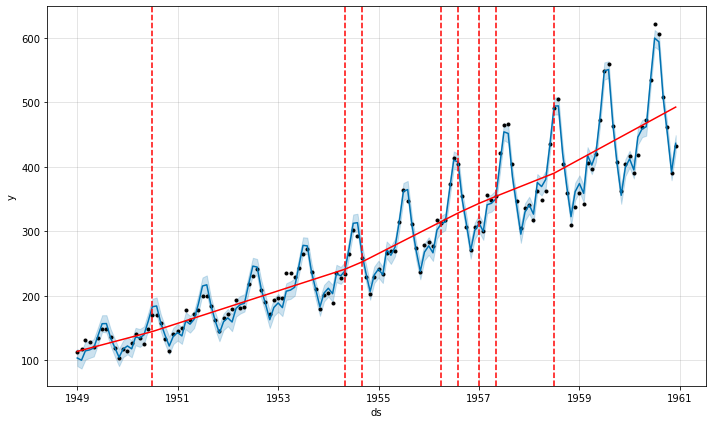

In [102]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)

## Evaluate

Note that the evaluation is being done on a **'multiplicative'** model!   
Under the 'Changing Seasonality' section above, the following was used: m = Prophet(seasonality_mode='multiplicative')

In [103]:
test['y']

132    417
133    391
134    419
135    461
136    472
137    535
138    622
139    606
140    508
141    461
142    390
143    432
Name: y, dtype: int64

In [104]:
predictions = forecast.iloc[-12:]['yhat']

In [105]:
predictions

132    412.328078
133    395.025885
134    446.050061
135    458.979964
136    462.061161
137    534.326562
138    599.585757
139    593.865993
140    507.162143
141    452.557268
142    391.807958
143    436.309189
Name: yhat, dtype: float64

In [106]:
# RMSE of Prophet using a 'multiplicative' model
# Note that RMSE equals 43 for an 'additive' model
rmse(test['y'],predictions)

11.606416813378292

In [107]:
# Use these stats to compare the RMSE with (e.g. compare the mean and std with RMSE)
test.describe()

,y
count,12.000000
mean,476.166667
std,77.737125
min,390.000000
25%,418.500000
50%,461.000000
75%,514.750000
max,622.000000


**New plots for the 'multiplicative' model**

<AxesSubplot:xlabel='ds'>

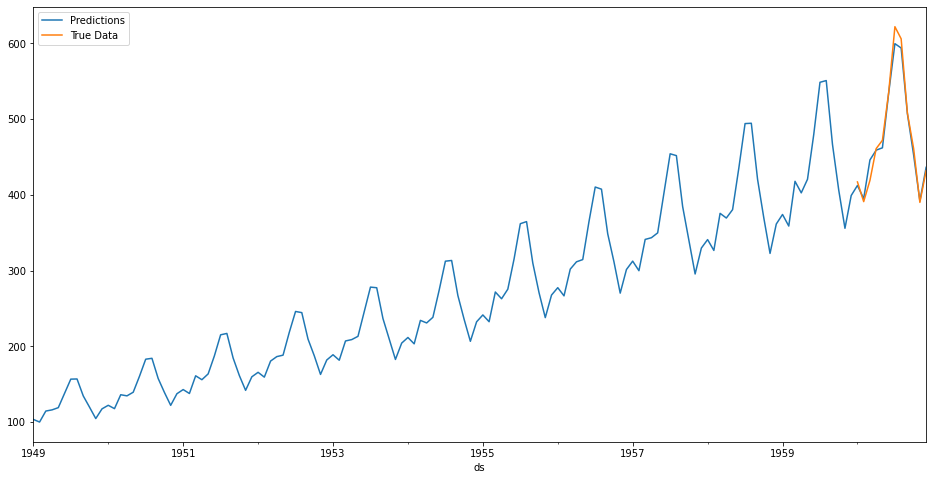

In [108]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(16,8))
test.plot(x='ds',y='y',label='True Data',legend=True,ax=ax)

<AxesSubplot:xlabel='ds'>

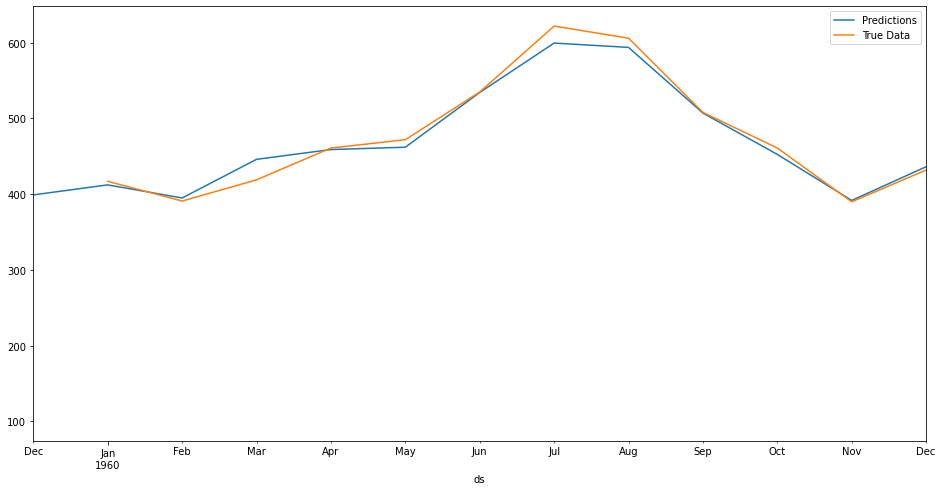

In [109]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(16,8))
test.plot(x='ds',y='y',label='True Data',legend=True,ax=ax,xlim=('1959-12-01','1960-12-01'))

## Facebook Prophet Diagnostics

In [110]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [111]:
len(df)

144

In [112]:
len(df)/12

12.0

In [113]:
# Initial 1 year training period
initial = 1 * 365
initial = str(initial) + ' days'

# Fold every 2 years
period = 2 * 365
period = str(period) + ' days'

horizon = 365
horizon = str(horizon) + ' days'

In [114]:
df_cv = cross_validation(m,initial=initial,period=period,horizon=horizon)

INFO:prophet:Making 5 forecasts with cutoffs between 1951-12-04 00:00:00 and 1959-12-02 00:00:00


In [115]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
55,1960-08-01,573.578381,560.679011,586.308202,606,1959-12-02
56,1960-09-01,496.395279,483.763149,509.671966,508,1959-12-02
57,1960-10-01,433.175028,419.827639,446.348541,461,1959-12-02
58,1960-11-01,379.492734,366.617969,392.033408,390,1959-12-02
59,1960-12-01,420.445224,406.646206,432.680393,432,1959-12-02


In [116]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,59 days,148.753019,12.196435,9.614419,0.035158,0.034658,0.034582,0.333333
1,60 days,399.375191,19.984374,15.901764,0.067469,0.045677,0.063703,0.250000
2,61 days,505.423455,22.481625,17.300288,0.070488,0.034658,0.066228,0.333333
3,88 days,586.499984,24.217762,19.500008,0.084299,0.075154,0.078788,0.333333
4,89 days,683.950288,26.152443,21.562053,0.072936,0.075154,0.069503,0.166667
5,90 days,815.529717,28.557481,24.774192,0.078522,0.094593,0.074904,0.083333
6,119 days,850.393434,29.161506,26.876457,0.095952,0.106529,0.091050,0.000000
7,120 days,1031.264683,32.113310,28.651805,0.096679,0.111351,0.091393,0.166667
8,121 days,909.431176,30.156777,26.993710,0.089712,0.092455,0.085266,0.166667
9,149 days,635.504866,25.209222,20.499611,0.071893,0.051519,0.069035,0.166667


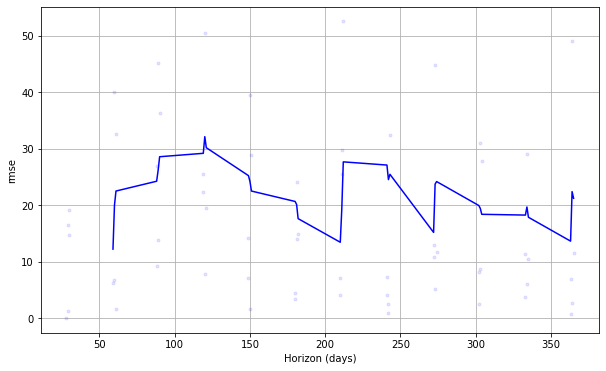

In [117]:
plot_cross_validation_metric(df_cv,metric='rmse');

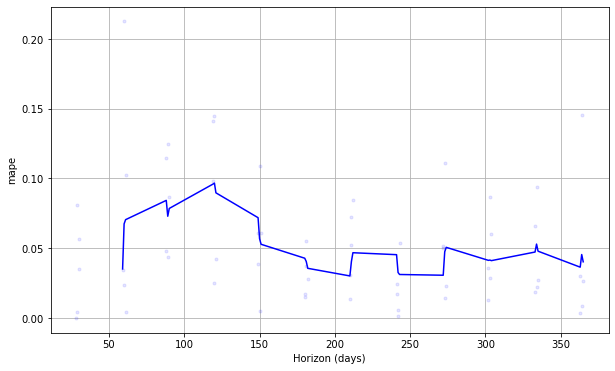

In [118]:
plot_cross_validation_metric(df_cv,metric='mape');

## New Prophet 12 Month Future Forecast with Multiplicative Model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Facebook Prophet - 12 Month Future Forecast - Multiplicative Model')

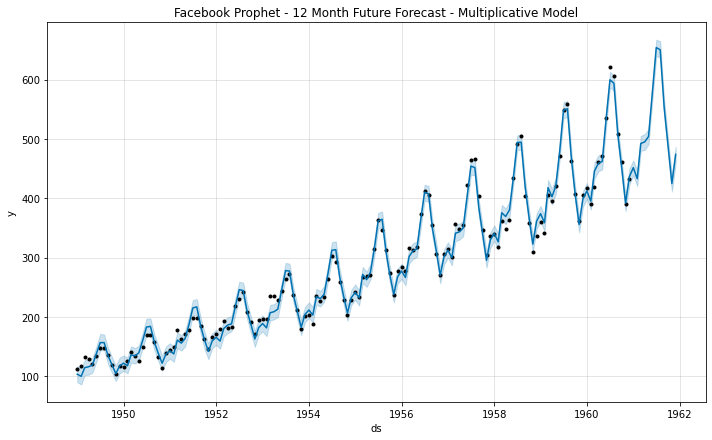

In [119]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)
m.plot(forecast);
plt.title('Facebook Prophet - 12 Month Future Forecast - Multiplicative Model')

Notice that the lower and upper bounds are reduced (shaded regions).

# Autoregressive Integrated Moving Average (ARIMA) Based Models

**In order to select an appropriate model (e.g. ARMA, ARIMA, Seasonal ARIMA, etc.), I need to know something about the data as each model addresses a different type of time series. This is why I have included the section, "Descriptive Statistics and Tests".**

## Descriptive Statistics and Tests

## Tests for Stationarity

It's obvious the data is non-stationary; however, for learning purposes, tests for stationarity will still be performed.

### Augmented Dickey-Fuller Test (ADF)

Null hypothesis is that the series is non-stationary.

In [120]:
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [121]:
df1.index.freq = 'MS'

In [122]:
df1.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [123]:
df1

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot:xlabel='Month'>

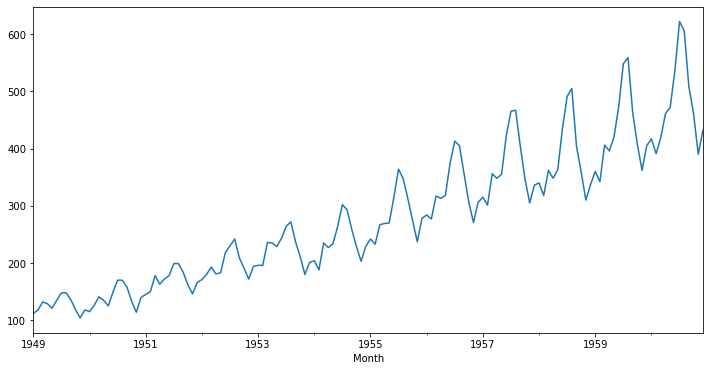

In [124]:
df1['Thousands of Passengers'].plot(figsize=(12,6))

**Function for running the augmented Dickey-Fuller test**

In [125]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

**Run the augmented Dickey-Fuller Test**

In [126]:
adf_test(df1['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Exposing Seasonality with Month and Quarter Plots

In [127]:
df1.head(3)

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [128]:
df1.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [129]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

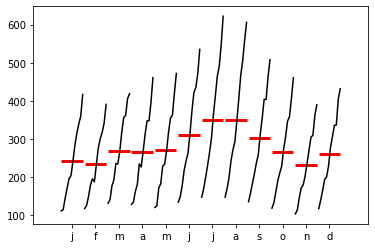

In [130]:
month_plot(df1['Thousands of Passengers']);

In [131]:
dfq = df1['Thousands of Passengers'].resample(rule='Q').mean()

In [132]:
dfq

Month
1949-03-31    120.666667
1949-06-30    128.333333
1949-09-30    144.000000
1949-12-31    113.666667
1950-03-31    127.333333
1950-06-30    136.333333
1950-09-30    166.000000
1950-12-31    129.000000
1951-03-31    157.666667
1951-06-30    171.000000
1951-09-30    194.000000
1951-12-31    158.000000
1952-03-31    181.333333
1952-06-30    194.000000
1952-09-30    227.000000
1952-12-31    185.666667
1953-03-31    209.333333
1953-06-30    235.666667
1953-09-30    257.666667
1953-12-31    197.333333
1954-03-31    209.000000
1954-06-30    241.666667
1954-09-30    284.666667
1954-12-31    220.333333
1955-03-31    247.333333
1955-06-30    284.666667
1955-09-30    341.000000
1955-12-31    263.000000
1956-03-31    292.666667
1956-06-30    335.000000
1956-09-30    391.000000
1956-12-31    294.333333
1957-03-31    324.000000
1957-06-30    375.000000
1957-09-30    445.333333
1957-12-31    329.333333
1958-03-31    340.000000
1958-06-30    382.000000
1958-09-30    466.666667
1958-12-31    335.3

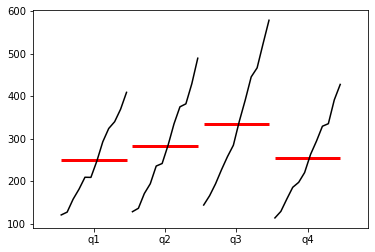

In [133]:
quarter_plot(dfq);

# Seasonal Autoregressive Integrated Moving Averages - SARIMA(p,d,q)(P,D,Q)m

P,D,Q represent the **seasonal** regression, differencing and moving average coefficients, and m represents the number of data points (rows) in each seasonal cycle.

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## Run pmdarima.auto_arima to obtain recommended orders.

For SARIMA orders, set seasonal=True and pass in an m value.

In [135]:
auto_arima(df1['Thousands of Passengers'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Fri, 02 Jul 2021   AIC                           1017.847
Time:                                     15:38:25   BIC                           1029.348
Sample:                                          0   HQIC                          1022.520
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5959      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.599      0.000      -1.057      -0.907
sigma2       129.3074     14.555      8.884      0.000     100.780     157.835
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Train Test Split

In [136]:
len(df1)

144

In [137]:
train = df1.iloc[:len(df)-12]

In [138]:
test = df1.iloc[len(df)-12:]

In [139]:
train

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


## Fit a SARIMA model to the training set

In [140]:
model = SARIMAX(train['Thousands of Passengers'],order=(2,1,1),seasonal_order=(0,1,0,12))
results = model.fit()
results.summary()

C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -447.483
Date:                             Fri, 02 Jul 2021   AIC                            902.967
Time:                                     15:38:25   BIC                            914.083
Sample:                                 01-01-1949   HQIC                           907.481
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5253      0.929     -0.566      0.572      -2.345       1.295
ar.L2          0.0110      0.275      0.040      0.968      -0.529       0.551
ma.L1          0.3064      0.935      0.328      0.743      -1.527       2.140
sigma2       108.0094     13.498      8.002      0.000      81.553     134.466
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.97   Prob(JB):                         0.50
Heteroskedasticity (H):               1.47   Skew:                            -0.09
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Obtain predicted values

In [141]:
start = len(train)

In [142]:
start

132

In [143]:
end = len(train) + len(test) -1

In [144]:
end

143

In [145]:
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA(2,1,1)(0,1,0,12) Predictions')

In [146]:
predictions

1960-01-01    425.135147
1960-02-01    408.815435
1960-03-01    471.901435
1960-04-01    462.399947
1960-05-01    486.128076
1960-06-01    538.276345
1960-07-01    614.195484
1960-08-01    625.239583
1960-09-01    529.215533
1960-10-01    473.228649
1960-11-01    428.221496
1960-12-01    471.225397
Freq: MS, Name: SARIMA(2,1,1)(0,1,0,12) Predictions, dtype: float64

## Plot predicted values against known values

<AxesSubplot:title={'center':'Airline Passengers'}, xlabel='Month'>

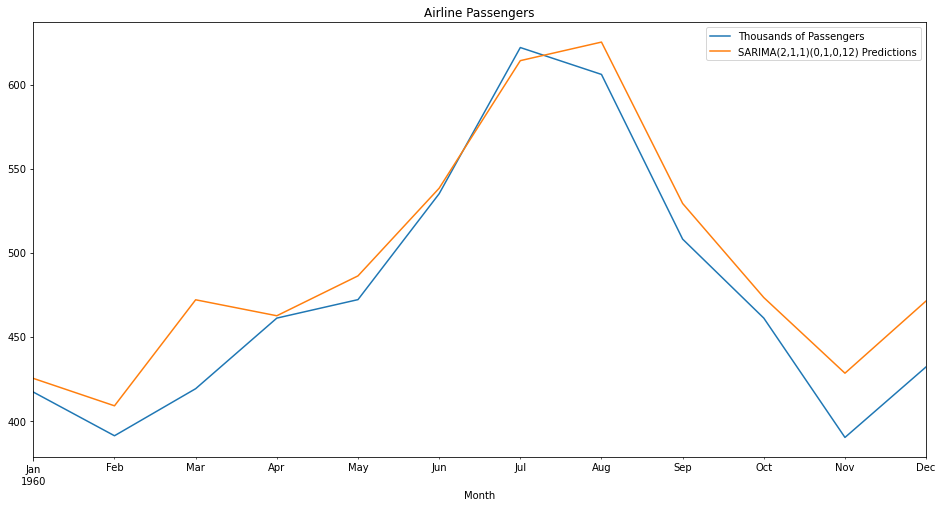

In [147]:
title = 'Airline Passengers'
ylabel = 'Thousands of Passengers'
xlabel = ''

ax = test['Thousands of Passengers'].plot(legend=True,figsize=(16,8),title=title)
predictions.plot(legend=True)

## Evaluate the model using MSE and RMSE

In [148]:
error1 = mean_squared_error(test['Thousands of Passengers'],predictions)

In [149]:
print(error1)

618.7211870141815


In [150]:
error2 = rmse(test['Thousands of Passengers'],predictions)

In [151]:
print(error2)

24.874106758116593


## Retrain the model on the full data and forecast one year into the future

In [152]:
model = SARIMAX(df1['Thousands of Passengers'],order=(2,1,1),seasonal_order=(0,1,0,12))
results = model.fit()

C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\user-pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [153]:
fcast = results.predict(len(df1),len(df1)+11,typ='levels').rename('SARIMA(2,1,1)(0,1,0,12) Forecast')

## Plot forecast values alongside the original values

<AxesSubplot:title={'center':'Airline Passengers'}, xlabel='Month'>

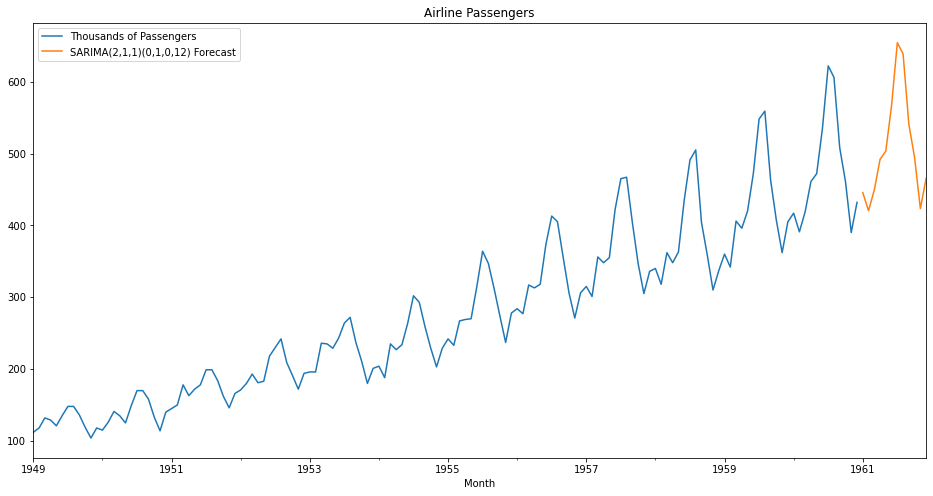

In [154]:
title = 'Airline Passengers'
ylabel = 'Thousands of Passengers'
xlabel = ''

ax = df1['Thousands of Passengers'].plot(legend=True,figsize=(16,8),title=title)
fcast.plot(legend=True)

# Recurrent Neural Network (RNN)

In [155]:
df2 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [156]:
df2.index.freq = 'MS'

In [157]:
df2.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [158]:
df2

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## Train Test Split

In [159]:
len(df2)

144

In [160]:
train = df2.iloc[:len(df2)-12]

In [161]:
test = df2.iloc[-12:]

In [162]:
train

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


In [163]:
test

,Thousands of Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [164]:
len(test)

12

## Scale / Normalise the Data

In [165]:
from sklearn.preprocessing import MinMaxScaler

In [166]:
scaler = MinMaxScaler()

In [167]:
scaled_train = scaler.fit_transform(train)

In [168]:
scaled_test = scaler.transform(test)

In [169]:
scaled_train

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703],
       [0.        ],
       [0.03076923],
       [0.02417582],
       [0.04835165],
       [0.08131868],
       [0.06813187],
       [0.04615385],
       [0.0989011 ],
       [0.14505495],
       [0.14505495],
       [0.11868132],
       [0.06373626],
       [0.02197802],
       [0.07912088],
       [0.09010989],
       [0.1010989 ],
       [0.16263736],
       [0.12967033],
       [0.14945055],
       [0.16263736],
       [0.20879121],
       [0.20879121],
       [0.17582418],
       [0.12747253],
       [0.09230769],
       [0.13626374],
       [0.14725275],
       [0.16703297],
       [0.1956044 ],
       [0.16923077],
       [0.17362637],
       [0.25054945],
       [0.27692308],
       [0.3032967 ],
       [0.23076923],
       [0.19120879],
       [0.14945055],
       [0.197

In [170]:
len(scaled_train)

132

In [171]:
scaled_test

array([[0.68791209],
       [0.63076923],
       [0.69230769],
       [0.78461538],
       [0.80879121],
       [0.94725275],
       [1.13846154],
       [1.1032967 ],
       [0.88791209],
       [0.78461538],
       [0.62857143],
       [0.72087912]])

In [172]:
len(scaled_test)

12

## Time Series Generator

My understanding:   
Generator ---> Automatically creates supervised data   
* The neural network is trained as a supervised model, thus we need to convert the data from a sequence to supervised data.   
    * format {features, target}   
* Look back is the number of previous days data to use to predict the value for the next day.   
* At a given day x(t), the features are the values of x(t-1), x(t-2),..., x(t-n) where n is look back.   

In [173]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [174]:
# Define the generator
look_back = 12 # The number of previous days data to use to predict the value for the next day
n_features = 1 # Univariate time series (not multivariate)
batch_size = 1 # Apparently works best with small batches

# Generator (supervised data) used for training
    # Source of the data and source of the targets come from the same data source
        # This is why there is "scaled_train,scaled_train" in the generator below
        # E.g. The first 12 values (data) are used to predict the 13th value (target), which come from the same source
        
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=look_back,batch_size=batch_size)

In [175]:
len(scaled_train)

132

In [176]:
len(train_generator) # 132-12 = 120

120

In [177]:
X,y = train_generator[0] # tuple unpacking

# X ---> feature data
# y ---> target

In [178]:
print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
[0.01758242 0.03076923 0.06153846 0.05494505 0.03736264 0.06813187
 0.0967033  0.0967033  0.07032967 0.03296703 0.         0.03076923]
Predict this y: 
 [[0.02417582]]


Looking at scaled_train, the 'given' array above shows the first 12 values, which are used to predict y, the 13th value in scaled_train.

In [179]:
X.shape # 3 dimensional

(1, 12, 1)

In [180]:
y.shape

(1, 1)

In [181]:
scaled_train[0:13]

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703],
       [0.        ],
       [0.03076923],
       [0.02417582]])

In [182]:
X,y = train_generator[1] # shifted 1

In [183]:
print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
[0.03076923 0.06153846 0.05494505 0.03736264 0.06813187 0.0967033
 0.0967033  0.07032967 0.03296703 0.         0.03076923 0.02417582]
Predict this y: 
 [[0.04835165]]


In [184]:
scaled_train[1:14] # shifted 1

array([[0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703],
       [0.        ],
       [0.03076923],
       [0.02417582],
       [0.04835165]])

In [185]:
X,y = train_generator[119] # Last array

In [186]:
print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
[0.51208791 0.56263736 0.52307692 0.66373626 0.64175824 0.69450549
 0.80879121 0.97582418 1.         0.78901099 0.66593407 0.56703297]
Predict this y: 
 [[0.66153846]]


In [187]:
scaled_train[-13:]

array([[0.51208791],
       [0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

## Create the model

In [188]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [189]:
# Define the model
model = Sequential()

# Simple RNN layer
    # input_shape = look_back x n_features = 12 x 1
    # LSTM = Long Short-Term Memory Network
model.add(LSTM(150,activation='relu',input_shape=(look_back,n_features)))

# Final prediction (one neuron per feature)
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [190]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


## Fit the model to the training generator

**Include EarlyStopping**

In [191]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=20)

# Validation data is required for early stopping:
    # Note: For the length parameter, I had to subtract 1 from look_back.
    
test_generator = TimeseriesGenerator(scaled_test,scaled_test,length=look_back-1,batch_size=batch_size)

In [192]:
# Fit the model to the training data
    # model.fit_generator() is no longer required as model.fit() now supports generators
    
model.fit(train_generator,epochs=500,callbacks=[early_stop],validation_data=test_generator)

# Get the following warning if you include "callbacks=[early_stop]" without "validation_data":
    # WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
# Looks like I need to include validation data for early stopping.
    # Here, I'll create validation data using the test data.
        # Create 'test_generator'.

Epoch 1/500
120/120 [==============================] - 3s 15ms/step - loss: 0.0510 - val_loss: 1.5183e-04
Epoch 2/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0110
Epoch 3/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 4/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0018
Epoch 5/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0477
Epoch 6/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 1.3559e-04
Epoch 7/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 8/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 9/500
120/120 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 2.3988e-05
Epoch 10/500
120/120 [==============================] - 0s 2ms/step - loss: 0.

In [193]:
loss_per_epoch = model.history.history['loss']

In [194]:
loss_per_epoch

[0.02559063583612442,
 0.01292211003601551,
 0.011120269075036049,
 0.007620747201144695,
 0.007727116346359253,
 0.00789713580161333,
 0.006528926081955433,
 0.006081221159547567,
 0.0032776338048279285,
 0.005902061238884926,
 0.0038081970997154713,
 0.0024075217079371214,
 0.0024426837917417288,
 0.0034991379361599684,
 0.004327232483774424,
 0.002285016467794776,
 0.0036484352312982082,
 0.0019835513085126877,
 0.0022101690992712975,
 0.002099042059853673,
 0.0021732565946877003,
 0.0021742444951087236,
 0.002489701844751835,
 0.0017502645496279001,
 0.002120340708643198,
 0.002113459398970008,
 0.0016325325705111027,
 0.0017030021408572793,
 0.0025439064484089613]

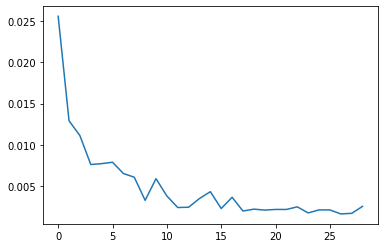

In [195]:
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [196]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<AxesSubplot:>

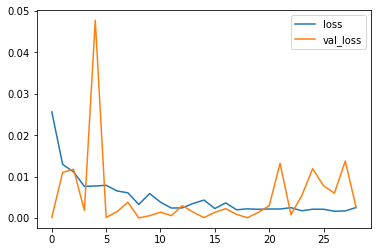

In [197]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on test data

In [198]:
# Last 12 values of the training set
first_eval_batch = scaled_train[-look_back:]

In [199]:
first_eval_batch

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

RNN requires 3-dimensional shape! Required to reshape first_eval_batch.

In [200]:
first_eval_batch.shape

(12, 1)

In [201]:
first_eval_batch = first_eval_batch.reshape((1,look_back,n_features))

In [202]:
first_eval_batch.shape

(1, 12, 1)

In [203]:
# Predict the first value of the scaled test set using the last 12 values of the scaled training set
    # Note the format is 2-dimensional (double brackets [[0.58457124]])
    
model.predict(first_eval_batch)

array([[0.6140917]], dtype=float32)

In [204]:
# To get 1-dimensional:

model.predict(first_eval_batch)[0]

array([0.6140917], dtype=float32)

In [205]:
# Actual first value of the scaled test set
scaled_test[0]

array([0.68791209])

But we want to be able to predict the entire test set, not just the first point.

Essentially, **Forecasting using the RNN model**.

In [206]:
test_predictions = [] # Empty placeholder (holding the predictions)

first_eval_batch = scaled_train[-look_back:]

# reshape to get RNN required 3-dimensional format (same format as the TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1,look_back,n_features))

# How far into the future will I forecast? Here, it is set to the length of the test set.
# You can expand on this to forecast further.
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0] # One timestep ahead of the 12 historical points
    test_predictions.append(current_pred) # Store the prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) # Update current batch to include the prediction

In [207]:
test_predictions

[array([0.6140917], dtype=float32),
 array([0.62221485], dtype=float32),
 array([0.6752661], dtype=float32),
 array([0.7077368], dtype=float32),
 array([0.7891695], dtype=float32),
 array([0.9516093], dtype=float32),
 array([1.1207293], dtype=float32),
 array([1.1277606], dtype=float32),
 array([0.9420535], dtype=float32),
 array([0.77298033], dtype=float32),
 array([0.7042224], dtype=float32),
 array([0.69615656], dtype=float32)]

### Inverse transformations and compare

Inversing basically reverses the scaling.

In [208]:
true_predictions = scaler.inverse_transform(test_predictions)

In [209]:
true_predictions

array([[383.41172093],
       [387.10775846],
       [411.24606961],
       [426.02023953],
       [463.0721181 ],
       [536.98223764],
       [613.93184388],
       [617.13109517],
       [532.63434106],
       [455.70605123],
       [424.42118341],
       [420.75123543]])

In [210]:
test

,Thousands of Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [211]:
test['Predictions'] = true_predictions

<ipython-input-211-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [212]:
test

,Thousands of Passengers,Predictions
Month,,
1960-01-01,417,383.411721
1960-02-01,391,387.107758
1960-03-01,419,411.246070
1960-04-01,461,426.020240
1960-05-01,472,463.072118
1960-06-01,535,536.982238
1960-07-01,622,613.931844
1960-08-01,606,617.131095
1960-09-01,508,532.634341


<AxesSubplot:xlabel='Month'>

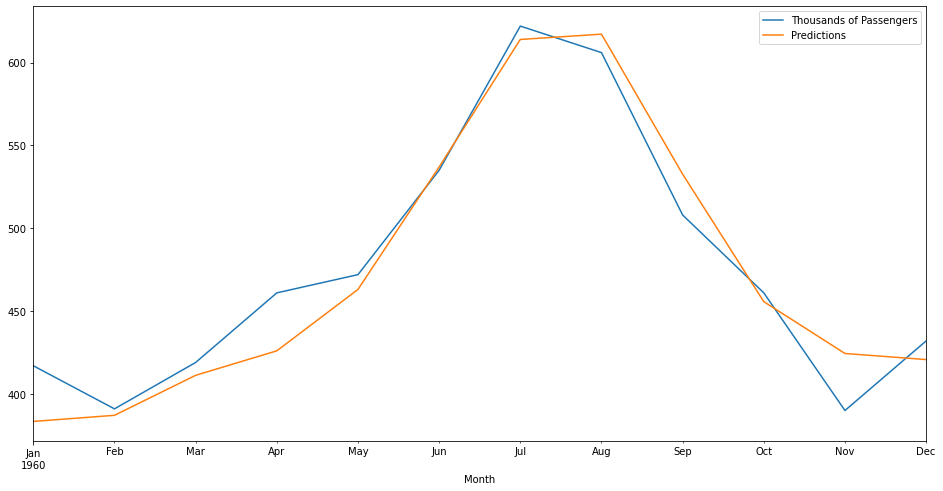

In [213]:
test.plot(figsize=(16,8))

In [214]:
RNN_error1 = mean_squared_error(test['Thousands of Passengers'],test['Predictions'])

In [215]:
print(RNN_error1)

387.1575918918065


In [216]:
RNN_error2 = rmse(test['Thousands of Passengers'],test['Predictions'])

In [217]:
print(RNN_error2)

19.67632058825548


# RNN Forecast

Note: When predicting the future, the model's output is fed back into it as input, which causes the model's noise and uncertainty to be repeated and amplified.

Possible parameters to tune when training:   
* look_back
* batch_size
* LSTM units
* number of epochs
   
Possibly enhance the architecture by stacking LSTM layers.

## Retrain on all the data

In [218]:
df3 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [219]:
df3.index.freq = 'MS'

In [220]:
scaled_df3 = scaler.transform(df3)

In [221]:
scaled_df3

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703],
       [0.        ],
       [0.03076923],
       [0.02417582],
       [0.04835165],
       [0.08131868],
       [0.06813187],
       [0.04615385],
       [0.0989011 ],
       [0.14505495],
       [0.14505495],
       [0.11868132],
       [0.06373626],
       [0.02197802],
       [0.07912088],
       [0.09010989],
       [0.1010989 ],
       [0.16263736],
       [0.12967033],
       [0.14945055],
       [0.16263736],
       [0.20879121],
       [0.20879121],
       [0.17582418],
       [0.12747253],
       [0.09230769],
       [0.13626374],
       [0.14725275],
       [0.16703297],
       [0.1956044 ],
       [0.16923077],
       [0.17362637],
       [0.25054945],
       [0.27692308],
       [0.3032967 ],
       [0.23076923],
       [0.19120879],
       [0.14945055],
       [0.197

In [222]:
df3_generator = TimeseriesGenerator(scaled_df3,scaled_df3,length=look_back,batch_size=batch_size)

In [223]:
#model.fit(df3_generator,epochs=56)
model.fit(df3_generator,epochs=500,callbacks=[early_stop],validation_data=df3_generator)

# Get the following warning if you include "callbacks=[early_stop]":
    # WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
# Do I need to include validation data for early stopping?
# Is early stopping required here?
    # I should use the number of epochs the training model stopped on due to early stopping?
    # Or, should I use "df3_generator" as the validation data?

Epoch 1/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 2/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 4/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 5/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0076
Epoch 8/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 9/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 10/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0016 - val_lo

132/132 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 82/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 8.7062e-04
Epoch 83/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 8.9044e-04
Epoch 84/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 85/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 86/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 87/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 88/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 89/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 9.4767e-04
Epoch 90/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0012 

Epoch 159/500
132/132 [==============================] - 0s 3ms/step - loss: 9.4333e-04 - val_loss: 7.6078e-04
Epoch 160/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 8.5599e-04
Epoch 161/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 8.0813e-04
Epoch 162/500
132/132 [==============================] - 0s 3ms/step - loss: 9.7269e-04 - val_loss: 7.2795e-04
Epoch 163/500
132/132 [==============================] - 0s 3ms/step - loss: 9.3195e-04 - val_loss: 7.0243e-04
Epoch 164/500
132/132 [==============================] - 0s 3ms/step - loss: 8.9761e-04 - val_loss: 0.0025
Epoch 165/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 7.2633e-04
Epoch 166/500
132/132 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 7.9968e-04
Epoch 167/500
132/132 [==============================] - 0s 3ms/step - loss: 9.5474e-04 - val_loss: 8.0211e-04
Epoch 168/500
132/132

132/132 [==============================] - 0s 3ms/step - loss: 5.7313e-04 - val_loss: 6.1657e-04
Epoch 234/500
132/132 [==============================] - 0s 3ms/step - loss: 6.3559e-04 - val_loss: 5.1491e-04
Epoch 235/500
132/132 [==============================] - 0s 3ms/step - loss: 6.8130e-04 - val_loss: 4.2958e-04
Epoch 236/500
132/132 [==============================] - 0s 3ms/step - loss: 5.6640e-04 - val_loss: 0.0011
Epoch 237/500
132/132 [==============================] - 0s 3ms/step - loss: 9.9323e-04 - val_loss: 0.0019
Epoch 238/500
132/132 [==============================] - 0s 3ms/step - loss: 7.6378e-04 - val_loss: 4.6107e-04
Epoch 239/500
132/132 [==============================] - 0s 3ms/step - loss: 7.4660e-04 - val_loss: 6.8573e-04
Epoch 240/500
132/132 [==============================] - 0s 3ms/step - loss: 6.5420e-04 - val_loss: 4.1542e-04
Epoch 241/500
132/132 [==============================] - 0s 3ms/step - loss: 6.9158e-04 - val_loss: 6.5415e-04
Epoch 242/500
132/132 [

In [224]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

In [225]:
loss_per_epoch = model.history.history['loss']

<AxesSubplot:>

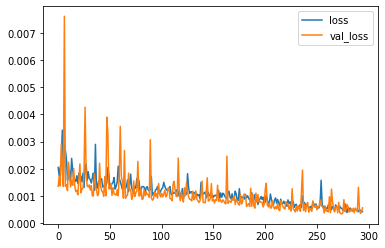

In [226]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Forecast

In [227]:
passenger_predictions = [] # Empty placeholder (holding the predictions)

first_eval_batch = scaled_df3[-look_back:]

# reshape to get RNN required 3-dimensional format (same format as the TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1,look_back,n_features))

for i in range(12): # Forecast 1 year (12 months) into the future
    current_pred = model.predict(current_batch)[0] # One timestep ahead of the 12 historical points
    passenger_predictions.append(current_pred) # Store the prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) # Update current batch to include the prediction

## Inverse transformations

In [228]:
passenger_predictions = scaler.inverse_transform(passenger_predictions)

In [229]:
len(passenger_predictions)

12

In [230]:
passenger_predictions

array([[461.927351  ],
       [443.59551036],
       [467.14116567],
       [520.12936527],
       [552.71233732],
       [628.99999583],
       [708.37476397],
       [681.96058714],
       [584.95177889],
       [529.12632728],
       [462.26328784],
       [487.46929073]])

## Plot the data

Need a new dataframe with the forecasted values and corresponding timestamps.

In [231]:
len(df3)

144

In [232]:
df3.tail(3)

,Thousands of Passengers
Month,
1960-10-01,461
1960-11-01,390
1960-12-01,432


Create new dataframe with only the forecasted dates and values:   
* Create a dictionary ---> {date1:value1, date2:value2, ... date12:value12}
* Create new dataframe using the dictionary
* Plot both df3 and the new dataframe

In [233]:
df3.index[len(df3)-1] # Subtract 1 because indexing starts at zero

Timestamp('1960-12-01 00:00:00', freq='MS')

In [234]:
fcast_dates = pd.date_range(start=(df3.index[len(df3)-1]),periods=13,freq='MS')

In [235]:
len(fcast_dates)

13

In [236]:
fcast_dates

DatetimeIndex(['1960-12-01', '1961-01-01', '1961-02-01', '1961-03-01',
               '1961-04-01', '1961-05-01', '1961-06-01', '1961-07-01',
               '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01',
               '1961-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [237]:
fcast_dates[0]

Timestamp('1960-12-01 00:00:00', freq='MS')

In [238]:
# Need to drop the first timestamp

fcast_dates = fcast_dates.drop(fcast_dates[0])

In [239]:
fcast_dates

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [240]:
len(fcast_dates)

12

In [241]:
# Create a dictionary

# zip() method:
    # This function pairs the list element with other list element at corresponding index in form of key-value pairs.

fcast_dict = dict(zip(fcast_dates,passenger_predictions))

In [242]:
fcast_dict

{Timestamp('1961-01-01 00:00:00', freq='MS'): array([461.927351]),
 Timestamp('1961-02-01 00:00:00', freq='MS'): array([443.59551036]),
 Timestamp('1961-03-01 00:00:00', freq='MS'): array([467.14116567]),
 Timestamp('1961-04-01 00:00:00', freq='MS'): array([520.12936527]),
 Timestamp('1961-05-01 00:00:00', freq='MS'): array([552.71233732]),
 Timestamp('1961-06-01 00:00:00', freq='MS'): array([628.99999583]),
 Timestamp('1961-07-01 00:00:00', freq='MS'): array([708.37476397]),
 Timestamp('1961-08-01 00:00:00', freq='MS'): array([681.96058714]),
 Timestamp('1961-09-01 00:00:00', freq='MS'): array([584.95177889]),
 Timestamp('1961-10-01 00:00:00', freq='MS'): array([529.12632728]),
 Timestamp('1961-11-01 00:00:00', freq='MS'): array([462.26328784]),
 Timestamp('1961-12-01 00:00:00', freq='MS'): array([487.46929073])}

In [243]:
fcast_dict.keys()

dict_keys([Timestamp('1961-01-01 00:00:00', freq='MS'), Timestamp('1961-02-01 00:00:00', freq='MS'), Timestamp('1961-03-01 00:00:00', freq='MS'), Timestamp('1961-04-01 00:00:00', freq='MS'), Timestamp('1961-05-01 00:00:00', freq='MS'), Timestamp('1961-06-01 00:00:00', freq='MS'), Timestamp('1961-07-01 00:00:00', freq='MS'), Timestamp('1961-08-01 00:00:00', freq='MS'), Timestamp('1961-09-01 00:00:00', freq='MS'), Timestamp('1961-10-01 00:00:00', freq='MS'), Timestamp('1961-11-01 00:00:00', freq='MS'), Timestamp('1961-12-01 00:00:00', freq='MS')])

In [244]:
fcast_dict.values()

dict_values([array([461.927351]), array([443.59551036]), array([467.14116567]), array([520.12936527]), array([552.71233732]), array([628.99999583]), array([708.37476397]), array([681.96058714]), array([584.95177889]), array([529.12632728]), array([462.26328784]), array([487.46929073])])

In [245]:
df4 = pd.DataFrame(index=fcast_dict.keys(),data=fcast_dict.values())

In [246]:
df4

,0
1961-01-01,461.927351
1961-02-01,443.595510
1961-03-01,467.141166
1961-04-01,520.129365
1961-05-01,552.712337
1961-06-01,628.999996
1961-07-01,708.374764
1961-08-01,681.960587
1961-09-01,584.951779
1961-10-01,529.126327


In [247]:
len(df4)

12

In [248]:
# Rename the column

df4.columns = ['Predictions']

In [249]:
df4

,Predictions
1961-01-01,461.927351
1961-02-01,443.595510
1961-03-01,467.141166
1961-04-01,520.129365
1961-05-01,552.712337
1961-06-01,628.999996
1961-07-01,708.374764
1961-08-01,681.960587
1961-09-01,584.951779
1961-10-01,529.126327


<AxesSubplot:title={'center':'Airline Passengers'}, xlabel='Month'>

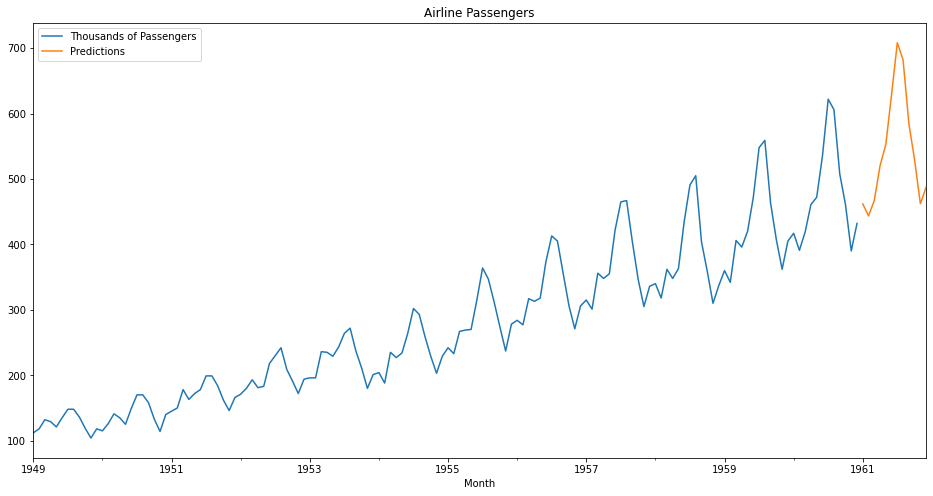

In [250]:
title = 'Airline Passengers'
ylabel = 'Thousands of Passengers'
xlabel = ''

ax = df3['Thousands of Passengers'].plot(legend=True,figsize=(16,8),title=title)
df4['Predictions'].plot(legend=True)